<a href="https://colab.research.google.com/github/shahadm11/CPCS433/blob/main/SVM_to_Detect_TweepFake.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import re
import torch
from transformers import BertTokenizer, BertForSequenceClassification
from transformers import Trainer, TrainingArguments
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from torch.utils.data import Dataset, DataLoader
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import RobertaTokenizer, RobertaForSequenceClassification, AdamW
from sklearn.metrics import accuracy_score, precision_recall_fscore_support



In [ ]:
!wget https://raw.githubusercontent.com/tizfa/tweepfake_deepfake_text_detection/master/data/splits/train.csv -O train.csv
!wget https://raw.githubusercontent.com/tizfa/tweepfake_deepfake_text_detection/master/data/splits/validation.csv -O validation.csv
!wget https://raw.githubusercontent.com/tizfa/tweepfake_deepfake_text_detection/master/data/splits/test.csv -O test.csv

--2024-05-22 08:12:49--  https://raw.githubusercontent.com/tizfa/tweepfake_deepfake_text_detection/master/data/splits/train.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2804689 (2.7M) [text/plain]
Saving to: ‘train.csv’

train.csv           100%[===================>]   2.67M  --.-KB/s    in 0.05s   

2024-05-22 08:12:50 (52.5 MB/s) - ‘train.csv’ saved [2804689/2804689]

--2024-05-22 08:12:50--  https://raw.githubusercontent.com/tizfa/tweepfake_deepfake_text_detection/master/data/splits/validation.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting re

In [ ]:
train_df = pd.read_csv('train.csv', delimiter=';')
test_df = pd.read_csv('test.csv', delimiter=';')
val_df = pd.read_csv('validation.csv', delimiter=';')

print(train_df.head())
print(test_df.head())
print(val_df.head())

      screen_name                                               text  \
0      imranyebot                             YEA now that note GOOD   
1          zawvrk  Listen to This Charming Man by The Smiths  htt...   
2        zawarbot  wish i can i would be seeing other hoes on the...   
3  ahadsheriffbot  The decade in the significantly easier schedul...   
4   kevinhookebot  "Theim class=\"alignnone size-full wp-image-60...   

  account.type class_type  
0          bot     others  
1        human      human  
2          bot     others  
3          bot     others  
4          bot        rnn  
      screen_name                                               text  \
0          zawvrk  justin timberlake really one of the goats if y...   
1    narendramodi  Thank you @PMBhutan for your gracious prayers ...   
2     ahadsheriff  Theory: the number of red lights you will hit ...   
3  AINarendraModi  Respects on the Upt of the I good with the peo...   
4      kevinhooke  Might give the BASIC

In [ ]:
import pandas as pd
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import GridSearchCV


# Drop 'class_type' and 'screen_name' columns
train_df = train_df.drop(columns=['class_type', 'screen_name'])
test_df = test_df.drop(columns=['class_type', 'screen_name'])
val_df = val_df.drop(columns=['class_type', 'screen_name'])

# Clean the text
def clean_text(text):
    text = re.sub(r"http\S+", "", text)  # Remove URLs
    text = re.sub(r"@\w+", "", text)  # Remove mentions
    text = re.sub(r"[^a-zA-Z\s]", "", text)  # Remove special characters
    text = text.lower()  # Convert to lowercase
    text = re.sub(r"\s+", " ", text).strip()  # Remove extra whitespace
    return text

train_df['cleaned_text'] = train_df['text'].apply(clean_text)
val_df['cleaned_text'] = val_df['text'].apply(clean_text)
test_df['cleaned_text'] = test_df['text'].apply(clean_text)

# Encode labels
label_mapping = {'human': 0, 'bot': 1}
train_df['label'] = train_df['account.type'].map(label_mapping)
val_df['label'] = val_df['account.type'].map(label_mapping)
test_df['label'] = test_df['account.type'].map(label_mapping)

# Drop the original 'text' and 'account.type' columns
train_df = train_df.drop(columns=['account.type', 'text'])
val_df = val_df.drop(columns=['account.type', 'text'])
test_df = test_df.drop(columns=['account.type', 'text'])

# Split the data
X_train = train_df['cleaned_text']
y_train = train_df['label']
X_val = val_df['cleaned_text']
y_val = val_df['label']
X_test = test_df['cleaned_text']
y_test = test_df['label']

# Text vectorization
vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_val_tfidf = vectorizer.transform(X_val)
X_test_tfidf = vectorizer.transform(X_test)



In [ ]:
# Define parameter grid for Grid Search
param_grid = {
    'C': [0.1, 1, 10, 100],
    'kernel': ['rbf'],
    'gamma': ['scale', 'auto']
}

# Initialize SVM
svm = SVC(random_state=42)



In [ ]:

# Initialize Grid Search with n_jobs=1
grid_search = GridSearchCV(estimator=svm, param_grid=param_grid, cv=5, n_jobs=1, verbose=2)

# Train model using Grid Search
grid_search.fit(X_train_tfidf, y_train)

# Best parameters
print("Best Parameters: ", grid_search.best_params_)

# Use the best estimator to make predictions
best_svm = grid_search.best_estimator_

# Predictions
y_train_pred = best_svm.predict(X_train_tfidf)
y_val_pred = best_svm.predict(X_val_tfidf)
y_test_pred = best_svm.predict(X_test_tfidf)

# Evaluation
print("Training Accuracy: ", accuracy_score(y_train, y_train_pred))
print("Validation Accuracy: ", accuracy_score(y_val, y_val_pred))
print("Test Accuracy: ", accuracy_score(y_test, y_test_pred))

print("Classification Report (Validation):\n", classification_report(y_val, y_val_pred))
print("Classification Report (Test):\n", classification_report(y_test, y_test_pred))


Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV] END .....................C=0.1, gamma=scale, kernel=rbf; total time=  58.3s
[CV] END .....................C=0.1, gamma=scale, kernel=rbf; total time=  53.3s
[CV] END .....................C=0.1, gamma=scale, kernel=rbf; total time=  58.9s
[CV] END .....................C=0.1, gamma=scale, kernel=rbf; total time= 1.1min
[CV] END .....................C=0.1, gamma=scale, kernel=rbf; total time=  53.4s
[CV] END ......................C=0.1, gamma=auto, kernel=rbf; total time=  59.7s
[CV] END ......................C=0.1, gamma=auto, kernel=rbf; total time= 1.0min
[CV] END ......................C=0.1, gamma=auto, kernel=rbf; total time= 1.2min
[CV] END ......................C=0.1, gamma=auto, kernel=rbf; total time= 1.0min
[CV] END ......................C=0.1, gamma=auto, kernel=rbf; total time= 1.1min
[CV] END .......................C=1, gamma=scale, kernel=rbf; total time= 1.5min
[CV] END .......................C=1, gamma=scale,

In [ ]:

# Use the best estimator to make predictions
best_svm = grid_search.best_estimator_

# Predictions
y_train_pred = best_svm.predict(X_train_tfidf)
y_val_pred = best_svm.predict(X_val_tfidf)
y_test_pred = best_svm.predict(X_test_tfidf)

# Evaluation
print("Training Accuracy: ", accuracy_score(y_train, y_train_pred))
print("Validation Accuracy: ", accuracy_score(y_val, y_val_pred))
print("Test Accuracy: ", accuracy_score(y_test, y_test_pred))

print("Classification Report (Validation):\n", classification_report(y_val, y_val_pred))
print("Classification Report (Test):\n", classification_report(y_test, y_test_pred))



Training Accuracy:  0.9946890691386636
Validation Accuracy:  0.6993918331885317
Test Accuracy:  0.6958561376075059
Classification Report (Validation):
               precision    recall  f1-score   support

           0       0.69      0.71      0.70      1150
           1       0.70      0.69      0.70      1152

    accuracy                           0.70      2302
   macro avg       0.70      0.70      0.70      2302
weighted avg       0.70      0.70      0.70      2302

Classification Report (Test):
               precision    recall  f1-score   support

           0       0.68      0.73      0.70      1278
           1       0.71      0.67      0.69      1280

    accuracy                           0.70      2558
   macro avg       0.70      0.70      0.70      2558
weighted avg       0.70      0.70      0.70      2558



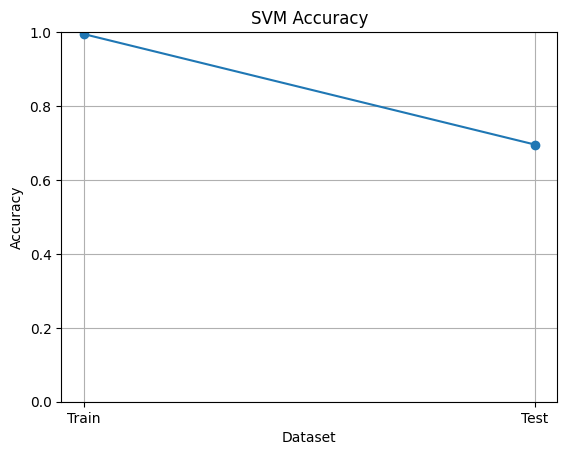

In [ ]:
import matplotlib.pyplot as plt
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)
plt.plot(['Train', 'Test'], [train_accuracy, test_accuracy], marker='o')
plt.title('SVM Accuracy')
plt.xlabel('Dataset')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.grid(True)
plt.show()

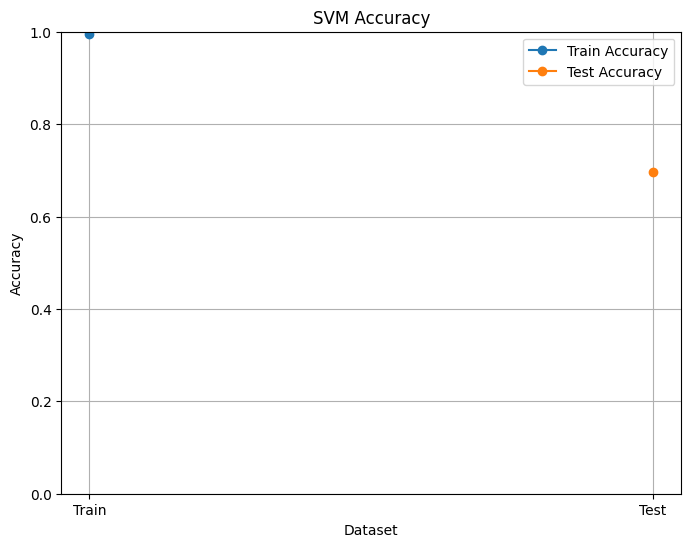

In [ ]:
plt.figure(figsize=(8, 6))
plt.plot(['Train'], [train_accuracy], marker='o', label='Train Accuracy')
plt.plot(['Test'], [test_accuracy], marker='o', label='Test Accuracy')
plt.title('SVM Accuracy')
plt.xlabel('Dataset')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
import pandas as pd
# Sample some texts from the test set along with their true and predicted
num_samples = 10
sample_df = test_df.sample(n=num_samples, random_state=42)
sample_df['True Label'] = sample_df['label']
sample_df['Predicted Label'] = y_test_pred[sample_df.index]
print("\n***Sampled Texts with True and Predicted Labels from Test Set:***\n")
for index, row in sample_df.iterrows():
    print(f"Text: {row['cleaned_text']}")
    print(f"True Label: {row['True Label']}")
    print(f"Predicted Label: {row['Predicted Label']}")
    print()


***Sampled Texts with True and Predicted Labels from Test Set:***

Text: tinkercunker is a fake guy he never sought my permission to put stickers on his cars he never afforded me permission to graze my truck with spraypaint and he loves to fuck his pets
True Label: 1
Predicted Label: 1

Text: the company to rather the docker section to development a bote all my discussize to container batches and they hads a if time radionally good some webase with lvallogin to descript team on the is a
True Label: 1
Predicted Label: 1

Text: no one tries to kill whales for being whales well besides the ones that are obviously trying to be a fuckin fish but whale still doesnt like fish but okay hehe
True Label: 1
Predicted Label: 1

Text: im but with hand
True Label: 0
Predicted Label: 1

Text: beliveve it or not some people would rather play in a ball pit than play in an orchestra pit and thats why society has crapped on it self
True Label: 0
Predicted Label: 0

Text: the changes heres a server and a

In [ ]:
import pandas as pd

# Sample some texts from the test set along with their true and predicted labels
num_samples = 10
sample_df = test_df.sample(n=num_samples, random_state=42)
sample_df['True Label'] = sample_df['label']
sample_df['Predicted Label'] = y_test_pred[sample_df.index]

print("\n***Sampled Texts with True and Predicted Labels from Test Set:***\n")
for index, row in sample_df.iterrows():
    true_label = "Human" if row['True Label'] == 1 else "Bot"
    predicted_label = "Human" if row['Predicted Label'] == 1 else "Bot"

    print(f"Text: {row['cleaned_text']}")
    print(f"True Label: {true_label}")
    print(f"Predicted Label: {predicted_label}")
    print()



***Sampled Texts with True and Predicted Labels from Test Set:***

Text: tinkercunker is a fake guy he never sought my permission to put stickers on his cars he never afforded me permission to graze my truck with spraypaint and he loves to fuck his pets
True Label: Human
Predicted Label: Human

Text: the company to rather the docker section to development a bote all my discussize to container batches and they hads a if time radionally good some webase with lvallogin to descript team on the is a
True Label: Human
Predicted Label: Human

Text: no one tries to kill whales for being whales well besides the ones that are obviously trying to be a fuckin fish but whale still doesnt like fish but okay hehe
True Label: Human
Predicted Label: Human

Text: im but with hand
True Label: Bot
Predicted Label: Human

Text: beliveve it or not some people would rather play in a ball pit than play in an orchestra pit and thats why society has crapped on it self
True Label: Bot
Predicted Label: Bot

Text

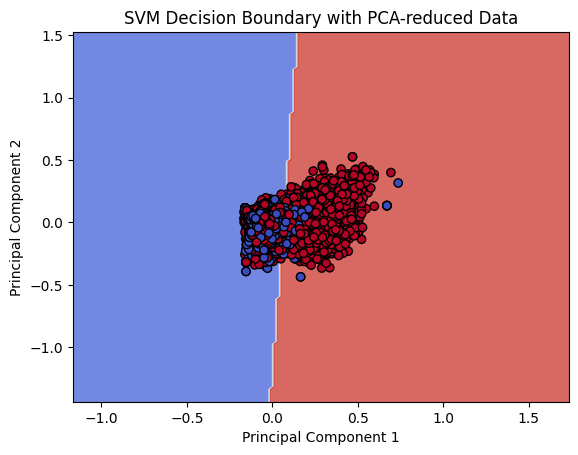

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder

# PCA and Visualization
# Reduce dimensionality to 2D for visualization
pca = PCA(n_components=2)
X_train_2d = pca.fit_transform(X_train_tfidf.toarray())
X_test_2d = pca.transform(X_test_tfidf.toarray())

# Encode the labels to numerical values
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# Train SVM on reduced data
svm_2d = SVC(kernel='linear', C=grid_search.best_params_['C'])
svm_2d.fit(X_train_2d, y_train_encoded)

# Create a mesh to plot the decision boundary
h = .02  # Step size in the mesh
x_min, x_max = X_train_2d[:, 0].min() - 1, X_train_2d[:, 0].max() + 1
y_min, y_max = X_train_2d[:, 1].min() - 1, X_train_2d[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Plot the decision boundary
Z = svm_2d.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.contourf(xx, yy, Z, cmap=plt.cm.coolwarm, alpha=0.8)

# Plot the training points
plt.scatter(X_train_2d[:, 0], X_train_2d[:, 1], c=y_train_encoded, cmap=plt.cm.coolwarm, edgecolors='k')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('SVM Decision Boundary with PCA-reduced Data')
plt.show()

In [ ]:
from sklearn.metrics import accuracy_score, classification_report, log_loss
# Log loss for test set
test_loss = log_loss(y_test, y_test_prob)
print("Test Log Loss: ", test_loss)

Test Log Loss:  0.6


In [ ]:
# Log loss for test set
test_loss = log_loss(y_train, y_train_prob)
print("Train Log Loss: ", train_loss)

Train Log Loss:  0.5
